In [1]:
import pandas as pd
import warnings
from pandas import read_csv

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


from datetime import datetime as dat, timedelta
from pandas import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
import pymssql
conn = pymssql.connect(server='192.168.10.89',port='62775',database='CARGOOPS',user='SVMRead',password='$vM@Kan00Dev')
cursor = conn.cursor()
cursor.execute('SELECT * FROM operationdetail')
row = cursor.fetchall()
df=pd.DataFrame(row)
df.columns=['servicecode','vesselcode','voyage','bound','cargotype','oprtype','containerstatus','soc','status','mode','opspol','opspod','originPort','deliveryPort','equipmenttype','twenty','forty','actdate','year','week']
df.head()

In [3]:
df['portPair'] =df['originPort']+"-"+df['deliveryPort']


/home/rupeshr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [11]:
df1=df.groupby(['actdate','servicecode','vesselcode','portPair'])['twenty','forty'].sum()
df1.reset_index(level=[0,1,2,3],inplace=True)


/home/rupeshr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [12]:
df1.head()

,actdate,servicecode,vesselcode,portPair,twenty,forty
0,2016-01-01 04:00:00,EAKX,NHT,CNTAO-KEMBA,8,0
1,2016-01-01 04:00:00,EAKX,NHT,CNXNG-KEMBA,10,1
2,2016-01-01 04:00:00,EAKX,NHT,CNXNG-UGKLA,1,1
3,2016-01-01 04:00:00,EAKX,NHT,IDJKT-KEMBA,2,0
4,2016-01-01 04:00:00,EAKX,NHT,MYPKG-AEJEA,1,14


In [13]:
var=df1['portPair'].value_counts()
var1=var.head(10)#var[(var >50)]
var1=pd.DataFrame(var1)
var1.reset_index(level=0,inplace=True)
var1.columns=['portPair','count']

In [ ]:
portdate=df1[(df1.portPair=='AEJEA-KEMBA')]
portdate.drop(['servicecode','vesselcode','portPair','forty'],axis=1,inplace=True)
portdate['actdate']=pd.to_datetime(portdate['actdate'])
forecast=portdate.set_index('actdate')
forecast['twenty'].replace(0,forecast['twenty'].median(),inplace=True)
forecast.head()
from statsmodels.tsa.seasonal import seasonal_decompose 
result = seasonal_decompose(forecast['twenty'].values,freq=30)   
result.plot()

                    servicecode vesselcode     portPair  twenty  forty
actdate                                                               
2016-01-01 19:00:00        EGMX        CLA  AEJEA-KEMBA      38      1
2016-01-01 19:10:00        EGMX        CLA  AEJEA-KEMBA      44     36
2016-01-10 17:15:00        EGMX        EJD  AEJEA-KEMBA      96     49
2016-01-16 20:55:00        EGMX        EMR  AEJEA-KEMBA       5     11
2016-01-16 21:00:00        EGMX        EMR  AEJEA-KEMBA      66     48
sucessfully
3.0642871660857627
-------------------------------------------------


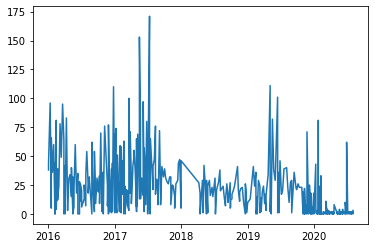

In [22]:

#for i in var1['portPair']:
    portdata=df1[(df1.portPair=='AEJEA-KEMBA')]
    #portdata.drop(['year','week','forty','portPair'],axis=1, inplace=True)
    forecastdate=portdata.set_index('actdate')
    
    forecastdate['twenty'].replace(0,forecastdate['twenty'].median(),inplace=True)
    plt.plot(forecastdate.twenty)
    
    print(forecastdate.head())
    warnings.filterwarnings("ignore")

    data=evaluate_Expo_model(forecastdate['twenty'].values)
    print(data)

    print("-------------------------------------------------")

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt
def evaluate_Expo_model(X):
    X=X.astype('float64')
    # prepare training dataset
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list() 
    for t in range(len(test)):
        model = ExponentialSmoothing(history, seasonal='add', seasonal_periods=7)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    print("sucessfully")
    # calculate out of sample error
    error = sqrt(mean_squared_error(test, predictions))

    return error